In [1]:
base_path = '/bigstore/binfo/mouse/Brain/Sequencing/Allen_10X_SmartSeqTypes/'
import os
loadings_fname= [i for i in os.listdir(base_path) if ('_dpnmf_loadings.npy' in i)&('merfish' in i)]
loadings_fname

['merfish_mu_1_dpnmf_loadings.npy',
 'merfish_mu_5_dpnmf_loadings.npy',
 'merfish_mu_10_dpnmf_loadings.npy',
 'merfish_mu_20_dpnmf_loadings.npy',
 'merfish_mu_50_dpnmf_loadings.npy',
 'merfish_mu_100_dpnmf_loadings.npy',
 'merfish_mu_500_dpnmf_loadings.npy',
 'merfish_mu_1000_dpnmf_loadings.npy',
 'log_merfish_mu_50_dpnmf_loadings.npy']

/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


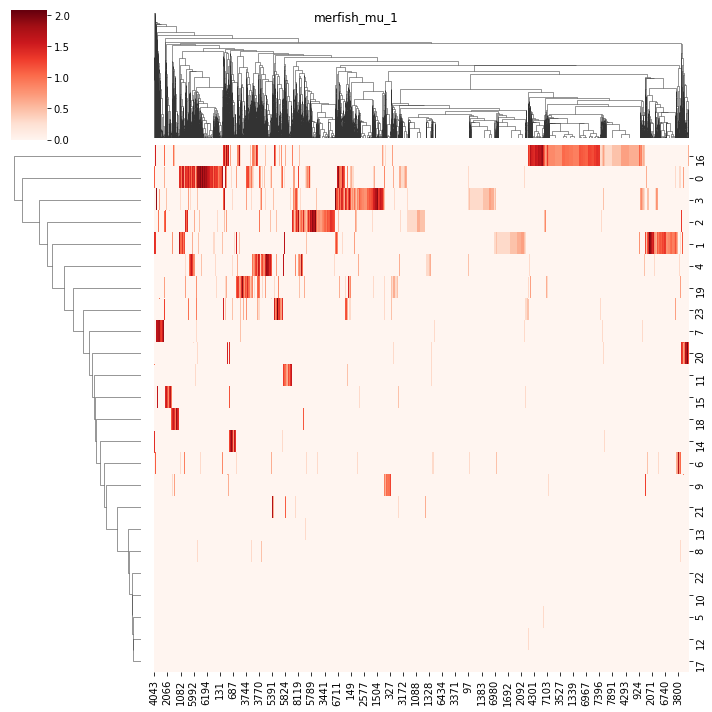

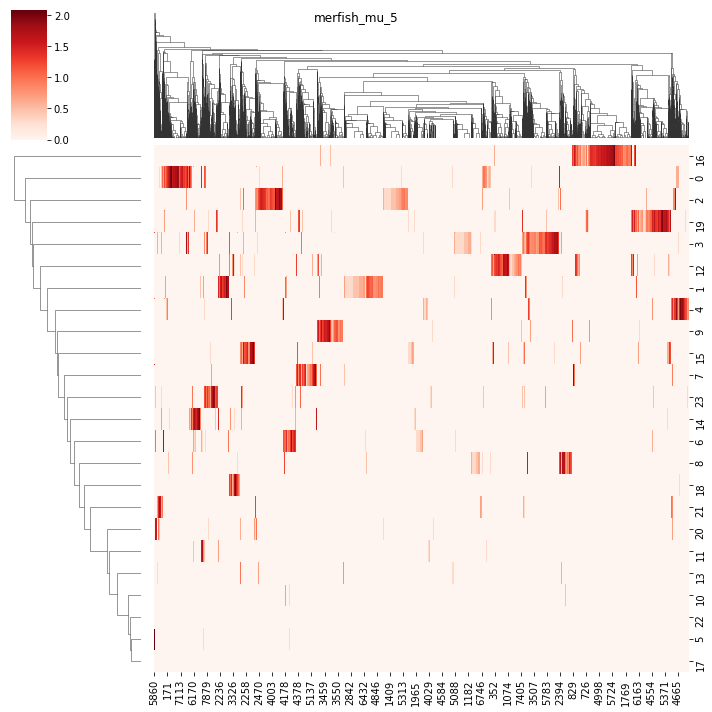

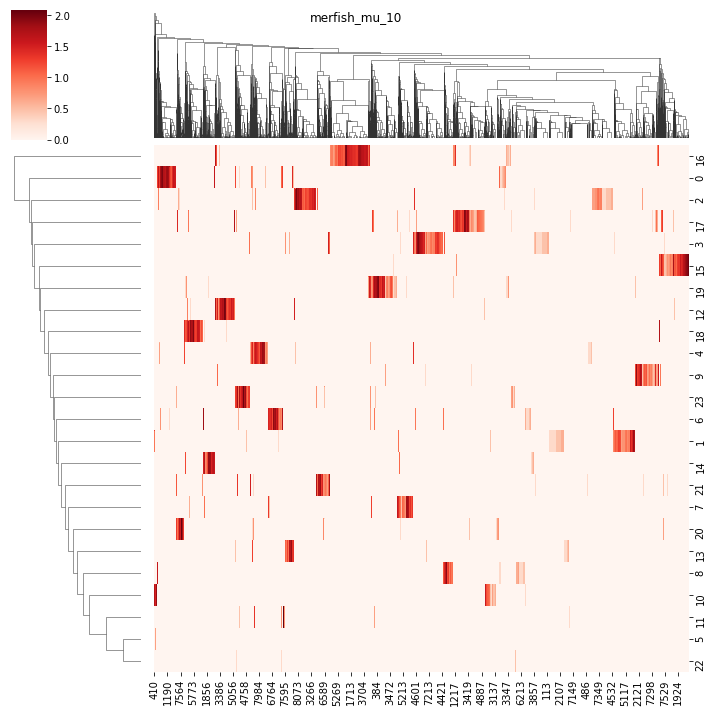

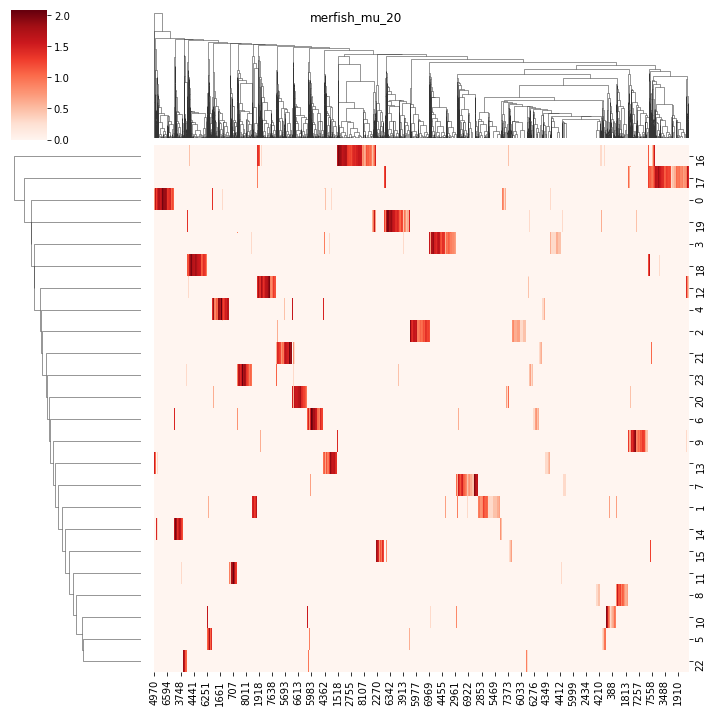

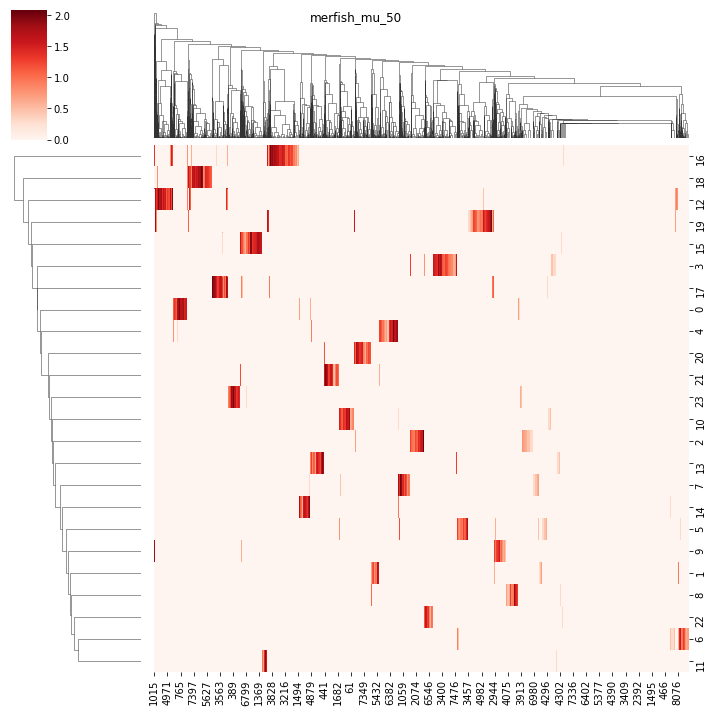

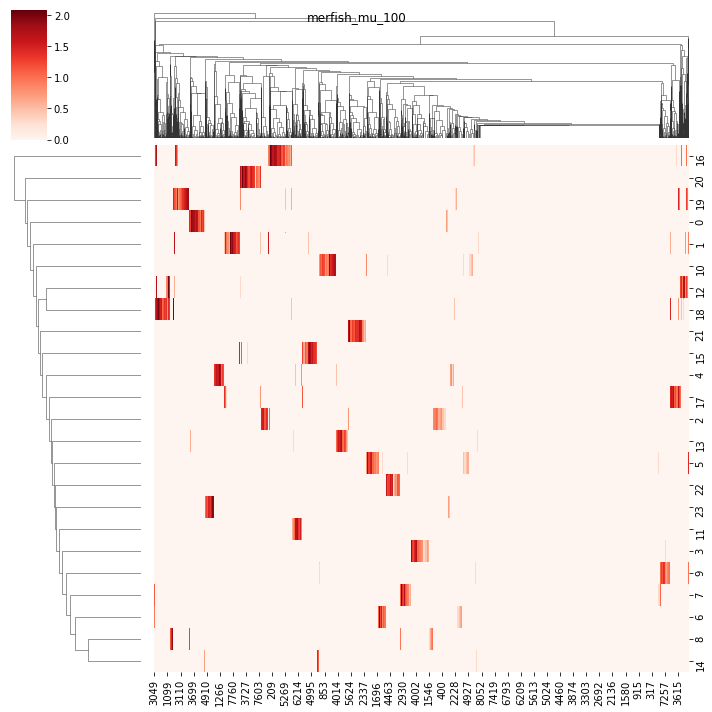

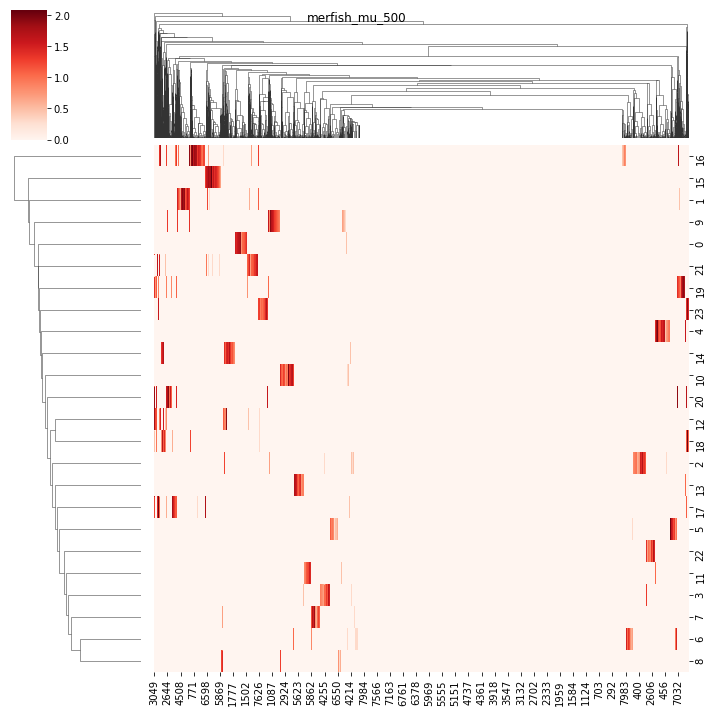

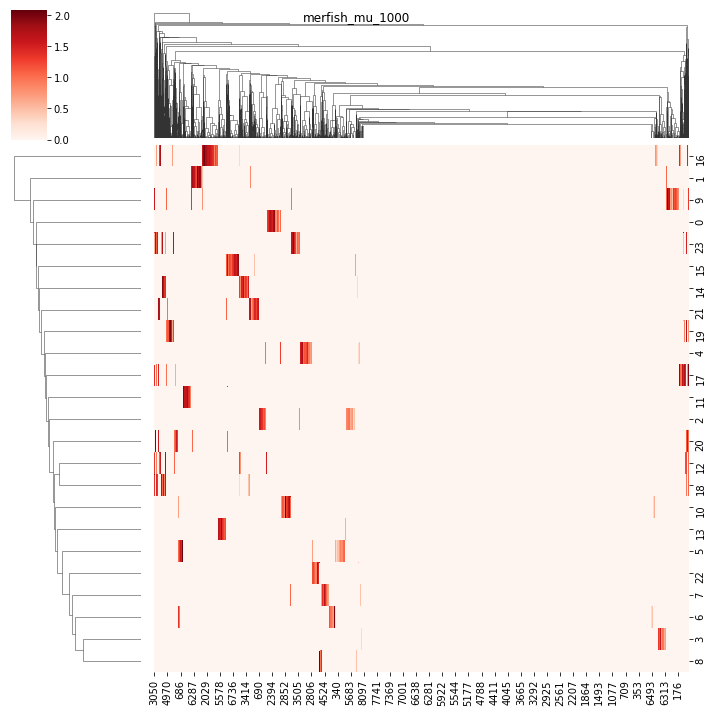

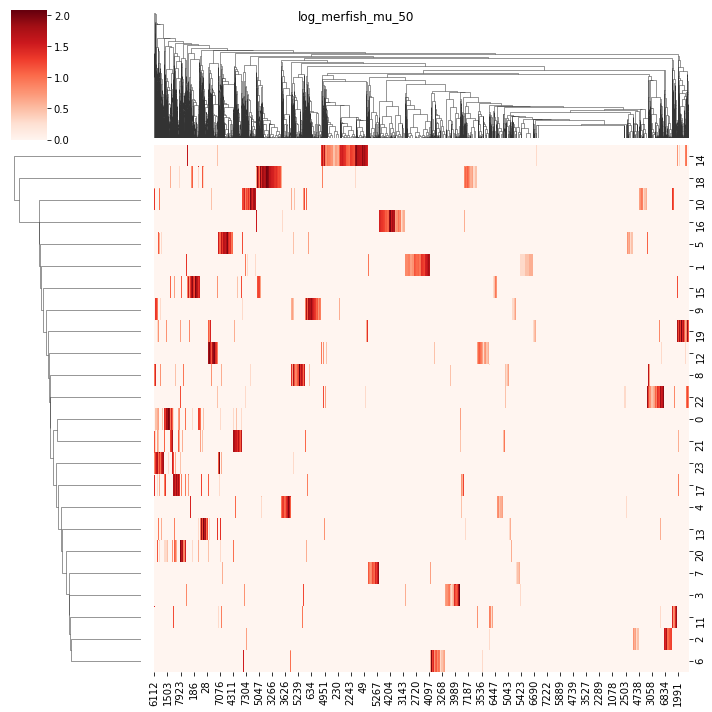

In [2]:
import sys
import seaborn as sns
import matplotlib.pyplot as plt
sys.setrecursionlimit(10000)
import numpy as np
loadings_dict = {}
for fname in loadings_fname:
    mu = fname.split('_d')[0]
    loadings = np.load(os.path.join(base_path,fname))
    probes = 120*loadings/np.max(loadings,axis=1)[:,None]
    probes = probes.astype(int)
    g = sns.clustermap(np.log10(probes+1),cmap="Reds")
    g.fig.suptitle(mu)
    g
    plt.show()

In [3]:
loadings = np.load(os.path.join(base_path,'merfish_mu_50_dpnmf_loadings.npy'))
probes = 120*loadings/np.max(loadings,axis=1)[:,None]
probes = probes.astype(int)

160909


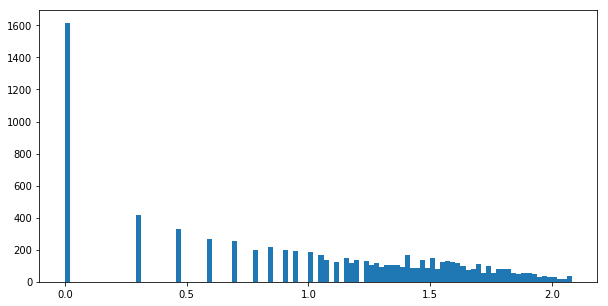

In [34]:
probes = 120*loadings/np.max(loadings,axis=1)[:,None]
probes = probes.astype(int)
print(np.sum(np.max(probes,axis=0)))
plt.figure(figsize=[10,5])
plt.hist(np.log10(np.max(probes,axis=0)+1),bins=100)
plt.show()

In [12]:
import pandas as pd
counts = np.load(os.path.join(base_path,'merfish_normcounts.npy'))
genes = list(pd.read_csv(os.path.join(base_path,'merfish_filtered_genes.csv'),index_col=0,header=None).index)
cells = list(pd.read_csv(os.path.join(base_path,'sorted_cells.csv'),index_col=0,header=None).index)
metadata = pd.read_csv(os.path.join(base_path,'sorted_metadata.csv'),index_col=0)
metadata['counts_loc'] = range(len(cells))
labels = np.array(list(metadata['cell_type_alias_label']))
celltypes = np.unique(labels)

/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
# Class Balance
from tqdm import tqdm
unqtypes = [i for i in np.unique(labels) if not i=='nan']
n = 100
class_balanced = np.empty((len(unqtypes)*n,len(genes)))
balanced_labels = np.empty((len(unqtypes)*n)).astype(str)
for i,ct in tqdm(enumerate(unqtypes),total=len(unqtypes)):
    start = i*n
    end = (i+1)*n
    ct_indexes = np.where(np.array(labels)==ct)[0]
    if len(ct_indexes)>n:
        ct_indexes = np.random.choice(ct_indexes,n,replace=False)
    else:
        ct_indexes = np.random.choice(ct_indexes,n,replace=True)
    balanced_labels[start:end] = ct
    class_balanced[start:end,:] = counts[ct_indexes,:]

100%|██████████| 373/373 [00:41<00:00,  8.91it/s]


In [35]:
compressed = np.matmul(class_balanced,probes.T)
compressed.shape

(37300, 24)

In [36]:
reduced_types = np.unique([i.split('_')[1] for i in unqtypes])
reduced_balanced_labels = np.array([i.split('_')[1] for i in balanced_labels])

In [37]:
reduced_types

array(['Astro', 'CA1', 'CA1-ProS', 'CA2-IG-FC', 'CA3', 'CR', 'CT SUB',
       'DG', 'Endo', 'L2 IT ENTl', 'L2 IT ENTm', 'L2 IT HATA',
       'L2 IT PAR', 'L2 IT ProS', 'L2 IT RSP-ACA', 'L2 IT RSPv',
       'L2/3 IT APr', 'L2/3 IT CTX', 'L2/3 IT ENTl', 'L2/3 IT PPP',
       'L2/3 IT TPE', 'L3 IT ENTl', 'L3 IT ENTm', 'L3 RSP-ACA',
       'L4/5 IT CTX', 'L4/5 IT TPE-ENT', 'L5 IT CTX', 'L5 IT TPE-ENT',
       'L5 NP CTX', 'L5 PPP', 'L5 PT CTX', 'L5 PT RSP-ACA', 'L5/6 IT CTX',
       'L6 CT CTX', 'L6 CT ENTm', 'L6 Car3', 'L6 IT CTX', 'L6 IT ENTl',
       'L6 IT RHP', 'L6 NP CT CTX', 'L6b CTX', 'L6b RHP', 'L6b/CT ENT',
       'Lamp5', 'Lamp5 Lhx6', 'Micro', 'NP PPP', 'NP SUB', 'Ndnf HPF',
       'OPC', 'Oligo', 'PVM', 'Pax6', 'Peri', 'ProS', 'Pvalb',
       'Pvalb Vipr2', 'SMC', 'SUB', 'SUB-ProS', 'Sncg', 'Sst',
       'Sst Chodl', 'V3d', 'VLMC', 'Vip'], dtype='<U15')

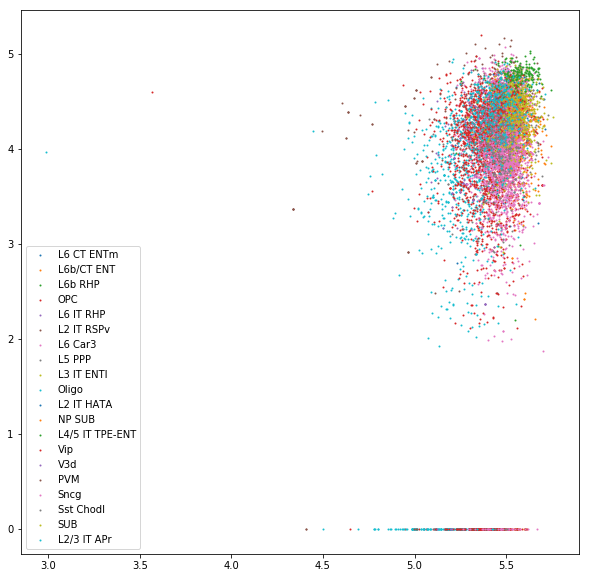

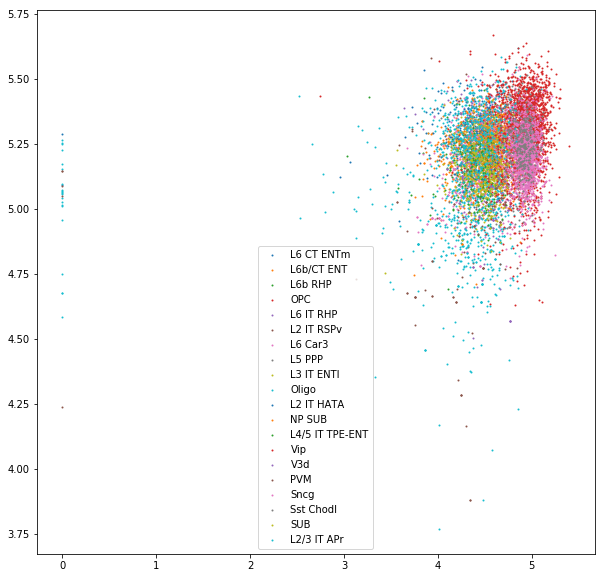

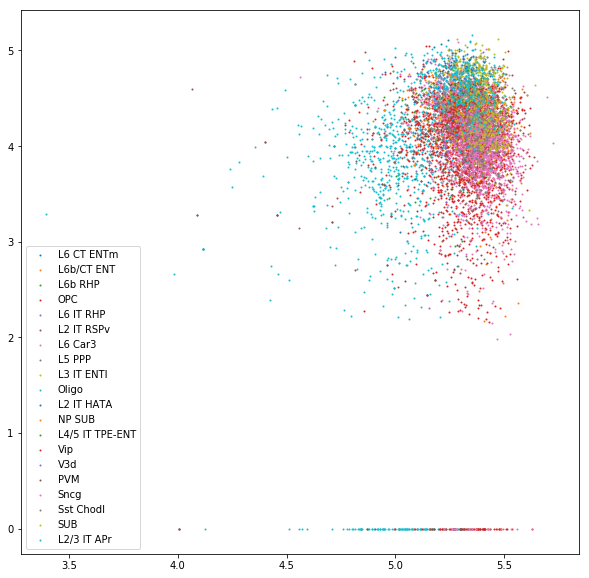

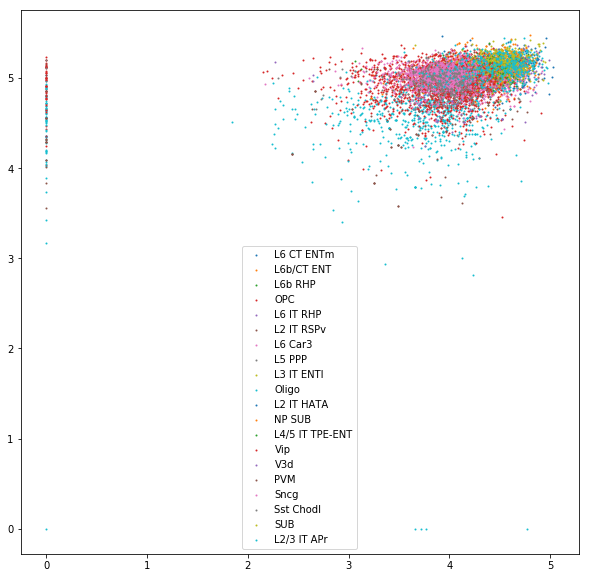

In [38]:
# View Compressed
reduced_types = np.unique([i.split('_')[1] for i in unqtypes])
reduced_balanced_labels = np.array([i.split('_')[1] for i in balanced_labels])
plt.figure(figsize=[10,10])
random_types = np.random.choice(reduced_types,20,replace=False)
dim1 = 0
dim2 = 1
for ct in random_types:
    mask = reduced_balanced_labels==ct
    plt.scatter(np.log10(compressed[mask,dim1]+1),np.log10(compressed[mask,dim2]+1),s=1,label=ct)
plt.legend()
plt.show()
dim1 = 2
dim2 = 3
plt.figure(figsize=[10,10])
for ct in random_types:
    mask = reduced_balanced_labels==ct
    plt.scatter(np.log10(compressed[mask,dim1]+1),np.log10(compressed[mask,dim2]+1),s=1,label=ct)
plt.legend()
plt.show()
dim1 = 4
dim2 = 5
plt.figure(figsize=[10,10])
for ct in random_types:
    mask = reduced_balanced_labels==ct
    plt.scatter(np.log10(compressed[mask,dim1]+1),np.log10(compressed[mask,dim2]+1),s=1,label=ct)
plt.legend()
plt.show()
dim1 = 6
dim2 = 7
plt.figure(figsize=[10,10])
for ct in random_types:
    mask = reduced_balanced_labels==ct
    plt.scatter(np.log10(compressed[mask,dim1]+1),np.log10(compressed[mask,dim2]+1),s=1,label=ct)
plt.legend()
plt.show()

In [39]:
"""
Validation Genes
Goal chose 150 to 500 genes
Best seperation possible of high level cell types
Best seperation of SST and CA1 cell types
"""

'\nGoal chose 150 to 500 genes\n'